<a href="https://colab.research.google.com/github/mojtabaSefidi/AI-Challenge-PoliceVsThieves/blob/main/Event_Detection_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Import & Installation

In [2]:
from collections import Counter, OrderedDict
import operator
import pandas as pd
import numpy as np
import itertools
import random
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import ast
from itertools import chain
from scipy import spatial

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing import text, sequence
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import pickle
import time
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

In [4]:
!pip install -q sentence_transformers
from sentence_transformers import SentenceTransformer

     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 5.8 MB 24.0 MB/s 
     |████████████████████████████████| 1.3 MB 44.9 MB/s 
     |████████████████████████████████| 182 kB 57.9 MB/s 
     |████████████████████████████████| 7.6 MB 62.2 MB/s 


In [5]:
!pip install -q transformers
import transformers
from transformers import AutoTokenizer, AutoConfig, TFAutoModelForTokenClassification

In [6]:
!pip install -q hazm
from hazm import *
from hazm import stopwords_list
!gdown 1-DGbE-g78E979ig_D-jR_L0Gfp5KY0qC
!unzip resources.zip

     |████████████████████████████████| 316 kB 13.5 MB/s 
     |████████████████████████████████| 233 kB 36.3 MB/s 
     |████████████████████████████████| 1.4 MB 37.1 MB/s 
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1-DGbE-g78E979ig_D-jR_L0Gfp5KY0qC 

unzip:  cannot find or open resources.zip, resources.zip.zip or resources.zip.ZIP.


In [7]:
Pars_Bert_Model = SentenceTransformer('HooshvareLab/bert-base-parsbert-uncased',device='cuda')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/HooshvareLab_bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Sub-Functions Needed

In [8]:
def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def remove_url(tweet):
    return re.sub(r"http\S+", " ", tweet)

def remove_usernames(tweet):
    return re.sub('@[^\s]+',' ',tweet)

def remove_English(tweet):
  return re.sub(r'\s*[A-Za-z]+\b', ' ' , tweet).rstrip()

def remove(text):
  text = text.replace('ھ','ه')
  text = text.replace('ئ','ی')
  text = text.replace('ؤ','و')
  text = text.replace('إ','ا')
  text = text.replace('أ','ا')
  text = text.replace('َ','')
  text = text.replace('ُ','')
  text = text.replace('ِ','')
  text = text.replace('ّ','')
  text = text.replace('ء','')
  text = text.replace('ـ','')
  text = text.replace('،',' ')
  text = text.replace('،',' ')
  text = re.sub('[^\u0621-\u0628\u062A-\u063A\u0641-\u0642\u0644-\u0648\u064E-\u0651\u0655\u067E\u0686\u0698\u06A9\u06AF\u06BE\u06CC\u06F0-\u06F9 ]', ' ', text)
  return re.sub("[^0-9\u0600-\u06FF]+", " ", text).strip()

def control_numeric(text):
  text = text
  pattern_integer = r'\d+'
  pattern_float = "\d+\.\d+"
  text = re.sub(pattern_float, ' ', text)
  text = re.sub(pattern_integer, ' ', text)
  return text

def remove_nan(dataset,column):
  dataset = dataset[dataset[column].notna()]
  return dataset

def clean_tweet(tweet):
  tweet = remove(tweet)
  tweet = remove_emoji(tweet)
  tweet = remove_usernames(tweet)
  tweet = remove_url(tweet)
  tweet = remove_English(tweet)
  tweet = control_numeric(tweet)
  return Normalizer().normalize(tweet)

def tweet_to_token(tweet):
    return word_tokenize(tweet)

def remove_StopWords(text):
  return Normalizer().normalize('  '.join([word for word in text.split() if word not in stop_words]))

def calculate_max_length(tweet_array):
  max_length = 0
  for tweet in tweet_array:
    if max_length < len(tweet):
      max_length = len(tweet)
  return max_length

def token2lemma(token):
  return Lemmatizer().lemmatize(token).split('#')[0]

def get_index(tupl, pos):
  return [i for i, tupl in enumerate(tupl) if tupl[-1] == pos]

def norm_token_persian(sentence):
  return word_tokenize(Normalizer().normalize(sentence))

def persian_pos(tokens):
  tagger = POSTagger(model='postagger.model')
  removed_roles = ['POSTP','CONJ','PUNC','NUM']
  part_of_speech = tagger.tag(tokens)
  remove_indices = list()
  for i in range(len(part_of_speech)):
    if part_of_speech[i][-1] in removed_roles:
      remove_indices.append(i)
  part_of_speech = [i for j, i in enumerate(part_of_speech) if j not in remove_indices]
  return part_of_speech

def persian_lemma_stem(POS):
  noun_index = get_index(POS,'N')
  # verb_index = get_index(POS,'V')
  POS = [*map(list, POS)]
  for i in noun_index:
    POS[i][0] = Stemmer().stem(POS[i][0])
  # for j in verb_index:
  #   POS[j][0] = token2lemma(POS[j][0])
  lemma_stem = [i[0] for i in POS]
  return POS, lemma_stem, ' '.join([word for word in lemma_stem])

def count_chars(text):
  return len(text)

def count_words(text):
  return len(text.split())

def generate_class_weight(y_train):    
    class_weights = {}
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight = "balanced", classes= classes, y= y_train)
    
    for i in range(len(classes)):
        class_weights[classes[i]] = weights[i]
    
    return class_weights

def segment_df2index(df_test, segment_col='Topic'):
  topic_indices = {}
  for topic in df_test['Topic'].unique():
    topic_indices[topic] = list(df_test[df_test['Topic']==topic].index.values)
  return topic_indices

def filter_by_index(np_array, row_indices, is_label=False):
    if is_label:
      return np_array[np.ix_(row_indices)]
    else:
      colunm_indices = list(range(0, np_array.shape[-1]))
      return np_array[np.ix_(row_indices, colunm_indices)]



In [9]:
import seaborn as sn
sn.set()
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, roc_auc_score


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_confusion_matrix(confusion_matrix, title='', cmap ='RdPu'):
    df = pd.DataFrame(confusion_matrix, range(len(confusion_matrix)), range(len(confusion_matrix)))
    plt.figure(figsize=(6,4))
    if title == '' :
        plt.title('Confusion Matrix')
    else:
        plt.title('Confusion Matrix' + ' ' + title)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df, annot=True, annot_kws={"size": 12},fmt='.0f',cmap=cmap) # font size
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


def plot_precision_recall_curve(actual_labels, prediction, title='', file_name=None):
    precision, recall, thresholds = precision_recall_curve(actual_labels, prediction)
    plt.figure(figsize=(8,6))
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

    # add axis labels to plot
    if title == '':
        plt.title(title)
    else:    
        plt.title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    # display plot
    plt.show()
    if file_name is not None:
        plt.savefig(file_name)     

def plot_roc_curve(actual_labels, prediction, title='', file_name=None):
    fpr, tpr, _ = roc_curve(actual_labels, prediction)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr)
    if title == '':
        plt.title(title)
    else:    
        plt.title('ROC Learning Curves')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()
    
    if file_name is not None:
        plt.savefig(file_name) 
        
        
def plot_metrics(history):
    metrics = ['loss', 'PRC', 'Precision', 'Recall']
    plt.figure(figsize=(10,10),linewidth = 7, edgecolor="whitesmoke")    

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])

    plt.legend()
    
def plot_auc_curve(actual_labels, prediction, model_name, title='', file_name = None):
    fpr, tpr, _ = roc_curve(actual_labels,  prediction)
    auc = roc_auc_score(actual_labels, prediction).round(4)
    plt.figure(figsize=(8,6))
    if title == '':
        plt.title(title)
    else:    
        plt.title('AUC Learning Curves')
    plt.plot(fpr,tpr, label='Model: '+ model_name + ", AUC=" + str(auc), color='red')
    plt.legend(loc=4)
    plt.show()
    if file_name is not None:
        plt.savefig(file_name)
  
def plot_history(history):
    
    plt.figure(figsize=(10,5),linewidth = 7, edgecolor="whitesmoke")    
    n = len(history.history['Accuracy'])
    
    plt.plot(np.arange(0,n)+1,history.history['Accuracy'], color='orange',marker=".")
    plt.plot(np.arange(0,n)+1,history.history['loss'],'b',marker=".")
    
    # offset both validation curves
    plt.plot(np.arange(0,n)+ 1,history.history['val_Accuracy'],'r')  
    plt.plot(np.arange(0,n)+ 1,history.history['val_loss'],'g')
    
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    
    # set vertical limit to 1
    plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle("Learning Curve", size=16, y=0.927)
    plt.show()


## DataProcessor Class

In [ ]:
stop_words = set(['زیرا','از','به','در','چه','پس','ولی','چون','یا','نیز','را','و', 'هم' , 'اگر' ,'تا' ,'اما' , 'که', 'با', 'اگرچه', 'آن', 'این', 'اکنون','همین','همان','چنانچه','آ‌نگاه','چنانچه','چنانچه','بر','لایک', 'برای','است','آیا'])


In [ ]:
class DataProcessor:
  
  def __init__(self, 
               Labeled_Dataset,
               Pars_Bert_Model,
               ):
        self.data = Labeled_Dataset
        self.Pars_Bert_Model = Pars_Bert_Model
    
  def split_data(self, split_ratio=0.2, validation_spilt=None):
    X_train, X_test, y_train, y_test = train_test_split(self.data.drop(['Label'], axis=1), self.data['Label'], test_size=split_ratio,
                                                        shuffle=True, stratify=self.data[['Label','Topic']])
    if not validation_spilt is None:
      X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_spilt,
                                                        shuffle=True, stratify=pd.concat([X_train['Topic'],y_train],axis=1))
      y_train = np.asarray(y_train).astype('int')
      y_test = np.asarray(y_test).astype('int')
      return X_train.reset_index(drop=True), X_test.reset_index(drop=True), X_validation.reset_index(drop=True), y_train, y_test, y_validation
    
    else:
      y_train = np.asarray(y_train).astype('int')
      y_test = np.asarray(y_test).astype('int')
      return X_train, X_test, y_train, y_test

  def column_selector(self, X_train, X_test, X_validation=None, feature_columns=['text']):
    if not X_validation is None:
      return X_train[feature_columns], X_test[feature_columns], X_validation[feature_columns]
    else:
      return X_train[feature_columns], X_test[feature_columns],

  def sampeler(self, X_train, y_train, strategy='Class_weight'):
    if strategy=='Over':
      sampler = RandomOverSampler(random_state=0)
    elif strategy=='Under':
      sampler = RandomUnderSampler(random_state=0)
    elif strategy=='Class_weight':
      return generate_class_weight(y_train)
    
    return sampler.fit_resample(X_train, y_train)

  def text2sequence(self, train_text, test_text, validation_text=None):
    print('1. Fit Tokenizer on Train...')
    tokenizer = text.Tokenizer()
    tokenizer.fit_on_texts(list(train_text))
    
    print('2. Convert Train Text to Sequence...')
    X_train_sequence = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(train_text),
                                                                  maxlen=calculate_max_length(train_text),
                                                                  padding='post', truncating='post')
    
    print('3. Convert Test Text to Sequence...')
    X_test_sequence = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(test_text),
                                                                 maxlen=calculate_max_length(train_text),
                                                                 padding='post', truncating='post')
    
    if not validation_text is None:
      print('4. Convert Validation Text to Sequence...')
      X_validation_sequence = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(validation_text),
                                                                         maxlen=calculate_max_length(train_text),
                                                                         padding='post', truncating='post')
      return X_train_sequence, X_test_sequence, X_validation_sequence
    
    else:
       return X_train_sequence, X_test_sequence
    
  def Bert_Embedding(self, train_text):
    print('1. Extract Tarin Embedding...')
    train_embedding = self.Pars_Bert_Model.encode(train_text)
    return train_embedding
    
    # print('Extract Test Embedding...')
    # test_embedding = self.Pars_Bert_Model.encode(test_text)
    
    # if not validation_text is None:
    #   print('Extract Validation Embedding...')
    #   validation_embedding = self.Pars_Bert_Model.encode(validation_text)
    #   return train_embedding, test_embedding, validation_embedding
    
    # else:
    #   return train_embedding, test_embedding
    
  def feature_extractor(self, X_train, X_test, X_validation=None):
    
    print('1. Remove StopWords from Train...')
    train_text = list(map(remove_StopWords, X_train['text']))
    print('2. Remove StopWords from Test...')
    test_text = list(map(remove_StopWords, X_test['text']))
    
    if not X_validation is None:
      print('3. Remove StopWords from Validation...')
      validation_text = list(map(remove_StopWords, X_validation['text']))

    print('text2sequence() Called...')
    if not X_validation is None:
      X_train_sequence, X_test_sequence, X_validation_sequence = self.text2sequence(train_text, test_text, validation_text)
    else:
      X_train_sequence, X_test_sequence = self.text2sequence(train_text, test_text)
    
    print('Bert_Embedding() Called...')
    X_train_embedding= self.Bert_Embedding(train_text)
    
    if not X_validation is None:
      return  X_train_sequence, X_train_embedding, X_test_sequence, X_validation_sequence
    else:
      return X_train_sequence, X_train_embedding, X_test_sequence,


  def Main(self):
    print('split_data() Called...')
    X_train, X_test, X_validation, y_train, y_test, y_validation = self.split_data(validation_spilt=0.15)
    topic_indices_test = segment_df2index(X_test, segment_col='Topic')
    print('column_selector() Called...')
    X_train, X_test, X_validation = self.column_selector(X_train, X_test, X_validation)
    print('sampeler() Called...')
    class_weight = self.sampeler(X_train, y_train)
    print('feature_extractor() Called...')
    X_train_sequence, X_train_embedding, X_test_sequence, X_validation_sequence = self.feature_extractor(X_train, X_test, X_validation)
    return X_train_sequence, X_train_embedding, y_train, X_test_sequence, y_test, X_validation_sequence, y_validation, class_weight, topic_indices_test

## Model Class

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='TP'),
      keras.metrics.FalsePositives(name='FP'),
      keras.metrics.TrueNegatives(name='TN'),
      keras.metrics.FalseNegatives(name='FN'), 
      keras.metrics.BinaryAccuracy(name='Accuracy'),
      keras.metrics.Precision(name='Precision'),
      keras.metrics.Recall(name='Recall'),
      keras.metrics.AUC(name='AUC'),
      keras.metrics.AUC(name='PRC', curve='PR')
]

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_Precision', 
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)

In [ ]:
class Model:

  def __init__(self, 
               X_train,
               y_train,
               train_embedding,
               X_validation=None,
               y_validation=None
               ):
    
        self.X_train = X_train
        self.y_train = y_train
        self.train_embedding = train_embedding
        if not y_validation is None:
          self.X_validation = X_validation
          self.y_validation = y_validation
  
  def define_cnn_model(self,               
                       filters = 250,               
                       kernel_size = 3,
                       units = 250,
                       drop_rate = 0.4,
                       learning_rate = 0.02):
      
      model = Sequential()
      
      #create embedding layer
      model.add(Embedding(self.train_embedding.shape[0], output_dim=self.train_embedding.shape[1], trainable = False
                        ,embeddings_initializer = keras.initializers.Constant(self.train_embedding)))    
      # 1st dropout
      model.add(Dropout(drop_rate))
      
      # 1st convolutional 1-D layer
      model.add(Conv1D(filters, kernel_size, padding = 'valid')) #no padding
      
      #max pooling layer
      model.add(MaxPooling1D())

      # 2nd convolutional 1-D layer
      model.add(Conv1D(filters, kernel_size, padding = 'valid')) #no padding
      
      #max pooling layer
      model.add(MaxPooling1D())
      
      # 3rd convolutional 1-D layer
      model.add(Conv1D(filters, kernel_size, padding = 'valid', activation = 'relu'))
      
      # global max pooling layer
      model.add(GlobalAveragePooling1D())
      
      # 1st dense layer
      model.add(Dense(units, activation = 'relu'))
      
      # 2nd dropout
      model.add(Dropout(drop_rate))
      
      # final dense layer
      model.add(Dense(1,activation = 'sigmoid'))
      
      # compile the model
      model.compile(loss = 'binary_crossentropy',    #since we are doing binary classification
                  optimizer = tensorflow.optimizers.SGD(learning_rate = learning_rate),
                  metrics = METRICS)
      
      print(model.summary())
      
      self.cnn_model = model

    
  def train_cnn(self, batch_size=128, epochs=100, class_weight=None):

    if not class_weight is None:
        cnn_history = self.cnn_model.fit(
            self.X_train, self.y_train,
            batch_size = batch_size,
            validation_data = [self.X_validation, self.y_validation],
            callbacks = [early_stopping],
            epochs = epochs,
            class_weight = class_weight,
            shuffle = True)
    else:
        cnn_history = self.cnn_model.fit(
            self.X_train, self.y_train,
            batch_size = batch_size,
            validation_data = [self.X_validation, self.y_validation],
            callbacks = [early_stopping],
            epochs = epochs,
            shuffle = True)
    
    return cnn_history
    
  def plot_cnn_training_history(self, history):
    print('1) Plot learning process based on different metrics...')
    plot_metrics(history)
    print('2) Plot learning curve...')
    return plot_history(history)

  def Evaluate_cnn(self, X_test_sequence, y_test, batch_size=128, threshold=0.3, title='', plot=True):
    prediction = self.cnn_model.predict(X_test_sequence, verbose=1, batch_size=batch_size)
    prediction[prediction >= threshold] = 1
    prediction[prediction < threshold] = 0
    plot_confusion_matrix(confusion_matrix(y_test, prediction), title=title, cmap ='Greens')
    print(classification_report(y_test, prediction))
    
    if plot:
      print('1) Plot ROC Curve...')
      plot_roc_curve(y_test, prediction, title='ROC Curve Of Model'+title, file_name=None)
      print('2) Plot AUC Curve...')
      plot_auc_curve(y_test, prediction, model_name='CNN', title='AUC Curve Of Model'+title, file_name = None)
      print('3) Plot Percision_Recall Curve......')
      plot_precision_recall_curve(y_test, prediction, title='Percision_Recall Curve Of Model'+title, file_name=None)
    
  def topic_based_evaluation(self, X_test_sequence, y_test, topic_indices_test):
    for topic, indices in topic_indices_test.items():
      feature = filter_by_index(X_test_sequence, indices)
      label = filter_by_index(y_test, indices, is_label=True)
      title = "(Evaluation of model on {topic} data)".format(topic = topic)
      self.Evaluate_cnn(feature, label, batch_size=128, threshold=0.3, title=title, plot=False)

  def Main(self):
    self.define_cnn_model()
    print()
    print('----------- Training of CNN Model Starts -----------')
    print()    
    self.train_cnn()
    self.plot_cnn_training_history()
    print()
    print('----------- Evaluation of CNN Model Starts -----------')
    print()
    self.Evaluate_cnn(title='Evaluation')


## Predict Class

In [ ]:
class Predict:
  
  def __init__(self, 
               SVM_model_tech,
               CNN_model_tech,
               tech_train_text,
               SVM_model_sport,
               CNN_model_sport,
               sport_train_text
               ):
        self.SVM_model_tech = SVM_model_tech
        self.CNN_model_tech = CNN_model_tech
        self.SVM_model_sport = SVM_model_sport
        self.CNN_model_sport = CNN_model_sport
        self.sport_train_text = sport_train_text
        self.tech_train_text = tech_train_text
        self.model = SentenceTransformer('HooshvareLab/bert-base-parsbert-uncased',device='cuda')
  
  def feature_extrction(self, pp_text, category):
    text_embedding = self.model.encode(pp_text)
    tokenizer = text.Tokenizer()
    if category == 'sport':
      tokenizer.fit_on_texts(list(self.sport_train_text))
    elif category == 'tech':
      tokenizer.fit_on_texts(list(self.tech_train_text))
    text_input = tokenizer.texts_to_sequences([pp_text])
    encoded_text = sequence.pad_sequences(text_input, maxlen = len(pp_text))
    return text_embedding, encoded_text

  def Main(self):
    while True:
      sample = input('Please Enter your Text: ')
      if sample == 'Quit':
        break
      category = input('Enter Category of Text (sport/tech): ')
      
      start_time = time.time()
      sample = clean_tweet(sample)
      text_embedding, encoded_text = self.feature_extrction(sample,category)

      if category == 'sport':
        cnn_prediction = self.CNN_model_sport.predict(encoded_text, verbose = 1, batch_size = 128)
        svm_prediction = self.SVM_model_sport.predict(text_embedding.reshape(-1, 768))
        end_time = time.time()
        print('input text: ',clean_tweet(sample))
        print('CNN model output: ', cnn_prediction)
        print('SVM model output: ', svm_prediction)
        print('Time Duration:',(end_time - start_time),'Seconds')
      
      elif category == 'tech':
        cnn_prediction = self.CNN_model_tech.predict(encoded_text, verbose = 1, batch_size = 128)
        svm_prediction = self.SVM_model_tech.predict(text_embedding.reshape(-1, 768))
        end_time = time.time()
        print('input text: ',clean_tweet(sample))
        print('CNN model output: ', cnn_prediction)
        print('SVM model output: ', svm_prediction)
        print('Time Duration:',(end_time - start_time),'Seconds')

#Test

In [88]:
%%time
final_dataset = pd.read_csv('/content/gdrive/MyDrive/Event Detection Final Dataset/EventDetection_All_Dataset.csv')
print(final_dataset.shape)
final_dataset.head()

(1730907, 8)
CPU times: user 15.2 s, sys: 2.57 s, total: 17.8 s
Wall time: 22.2 s


,datetime,text,retweet_count,like_count,username,hashtags,Label,Topic
0,2007-02-23 15:55:14+00:00,در یک نگاه نامزدهای جایزه اسکار بهترین فیلم,0.0,0.0,bbcpersian,Without_Hashtag,0,Art
1,2007-02-23 18:00:23+00:00,آیاتحریم‌های خارجی می‌تواند بر صنعت نفت ایران ...,0.0,0.0,bbcpersian,Without_Hashtag,0,Industry
2,2007-02-24 01:05:13+00:00,صفحه و ژه اسکار,0.0,0.0,bbcpersian,Without_Hashtag,0,Art
3,2007-02-24 15:00:10+00:00,عل رضا اسپهبد نقاش و گراف ست درگذشت,0.0,0.0,bbcpersian,Without_Hashtag,0,Art
4,2007-02-24 15:00:11+00:00,صفحه و ژه اسکار,0.0,1.0,bbcpersian,Without_Hashtag,0,Art


In [89]:
final_dataset['n_words']=final_dataset['text'].apply(count_words)
final_dataset = final_dataset[final_dataset['n_words']>=5]
final_dataset['datetime'] = pd.to_datetime(final_dataset['datetime'])
final_dataset.reset_index(drop=True,inplace=True)
final_dataset.head()

,datetime,text,retweet_count,like_count,username,hashtags,Label,Topic,n_words
0,2007-02-23 15:55:14+00:00,در یک نگاه نامزدهای جایزه اسکار بهترین فیلم,0.0,0.0,bbcpersian,Without_Hashtag,0,Art,8
1,2007-02-23 18:00:23+00:00,آیاتحریم‌های خارجی می‌تواند بر صنعت نفت ایران ...,0.0,0.0,bbcpersian,Without_Hashtag,0,Industry,9
2,2007-02-24 15:00:10+00:00,عل رضا اسپهبد نقاش و گراف ست درگذشت,0.0,0.0,bbcpersian,Without_Hashtag,0,Art,8
3,2007-02-24 18:00:10+00:00,تظاهرات ضد جنگ در لندن,0.0,0.0,bbcpersian,Without_Hashtag,0,Social,5
4,2007-02-25 17:20:10+00:00,جهان در انتظار مراسم اسکار,0.0,0.0,bbcpersian,Without_Hashtag,0,Art,5


In [90]:
def cosine_similarity(vector1, vector2):
  return round(1 - spatial.distance.cosine(vector1, vector2),4)

def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return round(intersection_cardinality/float(union_cardinality),4)

def calculate_embedding(text_numpy_array, Pars_Bert_Model=Pars_Bert_Model):
  return Pars_Bert_Model.encode(text_numpy_array)

def calculate_cooccurrence(text, nameEntity):
  return text.lower().split().count(nameEntity)

def get_unique_hashtags(df_final_dataset, hashtag_col='hashtags', no_hashtag='Without_Hashtag'):
  x = df_final_dataset[df_final_dataset.loc[:,hashtag_col]!=no_hashtag][hashtag_col].apply(ast.literal_eval)
  return set(list(chain.from_iterable(list(x))))

def clean_entities(list_entities):
  return set(i[0] for i in set(list(chain.from_iterable(list([x for x in list_entities if x])))) if not '#' in i[0])

In [110]:
def load_model(NER_model_path):

    try:
        config = AutoConfig.from_pretrained(NER_model_path)
        tokenizer = AutoTokenizer.from_pretrained(NER_model_path)
        model = TFAutoModelForTokenClassification.from_pretrained(NER_model_path)
        labels = list(config.label2id.keys())

        return model, tokenizer, labels
    except:
        return [None] * 3

def NER_detection(df_texts, model, tokenizer, labels):

    if not model or not tokenizer or not labels:
        return 'Something wrong has been happened!'
    
    output_predictions = []
    i = 1
    for text in df_texts:
        if i % 1000 == 0:
          print(str(i) + ' samples passed.')
        tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(text)))
        inputs = tokenizer.encode(text, return_tensors="tf")
        outputs = model(inputs)[0]
        predictions = tf.argmax(outputs, axis=2)
        predictions = [(token, labels[prediction]) for token, prediction in zip(tokens, predictions[0].numpy()) if labels[prediction] != 'O']
        output_predictions.append(predictions)
        i+=1

    return output_predictions


In [112]:
# df_texts = final_dataset[final_dataset['datetime']<='2007-05-23']
df_texts = final_dataset[final_dataset['datetime']<='2010-02-23']['text']

In [113]:
%%time
NER_model_path = 'HooshvareLab/bert-base-parsbert-peymaner-uncased'
NER_model, tokenizer, labels = load_model(NER_model_path)
peyman_NER = NER_detection(df_texts, NER_model, tokenizer, labels)

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-peymaner-uncased were not used when initializing TFBertForTokenClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForTokenClassification were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-peymaner-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


1000 samples passed.
2000 samples passed.
3000 samples passed.
4000 samples passed.
CPU times: user 29min 6s, sys: 1min 5s, total: 30min 12s
Wall time: 23min 14s


In [114]:
%%time
NER_model_path = 'HooshvareLab/bert-base-parsbert-ner-uncased'
NER_model, tokenizer, labels = load_model(NER_model_path)
Parsbert_NER = NER_detection(df_texts, NER_model, tokenizer, labels)

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-ner-uncased were not used when initializing TFBertForTokenClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForTokenClassification were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-ner-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


KeyboardInterrupt: ignored

In [122]:
def generate_occurrence_matrix(df_texts, list_nameEntity):
  frequency = {}
  for nameEntity in list_nameEntity:
    occurance = np.zeros(len(df_texts), dtype=np.int8)
    for i, text in enumerate(df_texts):
      occurance[i] = calculate_cooccurrence(text, nameEntity)
    frequency[nameEntity] = occurance
  return frequency

def generate_occurrence_matrix2(df_texts, list_nameEntity):
  occurance = np.zeros(shape=(len(list_nameEntity),len(df_texts)), dtype=np.int8)
  for i, text in enumerate(df_texts):
    for j, nameEntity in enumerate(list_nameEntity):
      occurance[j,i] = calculate_cooccurrence(text, nameEntity)
  return occurance

In [116]:
%%time
x = generate_occurrence_matrix(final_dataset[final_dataset['datetime']<='2010-02-23']['text'], clean_entities(peyman_NER))

CPU times: user 28.8 s, sys: 86.8 ms, total: 28.9 s
Wall time: 30 s


In [117]:
%%time
y = generate_occurrence_matrix2(final_dataset[final_dataset['datetime']<='2010-02-23']['text'], clean_entities(peyman_NER))
keys = clean_entities(peyman_NER)

CPU times: user 21.2 s, sys: 33.6 ms, total: 21.2 s
Wall time: 21.2 s


In [118]:
def remove_useless_entities(entities, occurrence):
  useless_index = np.where(occurrence.sum(1) == 0)[0]
  occurrence = np.delete(occurrence, useless_index, 0)
  entities = set(x for i, x in enumerate(list(entities)) if i not in useless_index)
  return entities, occurrence

In [119]:
def similarity_entity(entities, occurrence, similarity_function='cosine'):
  similarity = np.zeros(shape=(len(entities),len(entities)), dtype=np.float16)
  for i, entity1 in enumerate(occurrence):
    for j, entity2 in enumerate(occurrence):
      if similarity_function == 'cosine' :
        similarity[i,j] = cosine_similarity(entity1, entity2)
      elif similarity_function == 'jaccard':
        similarity[i,j] = jaccard_similarity(entity1, entity2)
  return similarity

In [120]:
keys, occurrence = remove_useless_entities(keys, occurrence)
similarity_array = similarity_entity(keys, occurrence)

In [121]:
df = pd.DataFrame(data=similarity_array,
             index = keys,
             columns = keys,
             )
df

,سمر,هییت,پکن,تویتر,بایرن,مدودف,اوت,حقیقت,تحکیم,انال,...,افشین,حجاریان,اتحادیه,مغولستان,معروف,اسراییلی,سفلی,هیتلر,حاج,[CLS]
سمر,1.000000,0.0,0.0,0.0,0.003799,0.002600,0.0,0.0,0.010498,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
هییت,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
پکن,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
تویتر,0.000000,0.0,0.0,1.0,0.000000,0.015297,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
بایرن,0.003799,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
اسراییلی,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
سفلی,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
هیتلر,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
حاج,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
!pip install -q cdlib
from cdlib import algorithms


     |████████████████████████████████| 3.3 MB 13.6 MB/s 
     |████████████████████████████████| 174 kB 51.9 MB/s 
     |████████████████████████████████| 2.2 MB 30.7 MB/s 
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'karateclub', 'wurlitzer', 'graph_tool', 'leidenalg'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


MultiGraph with 500 nodes and 32403 edges


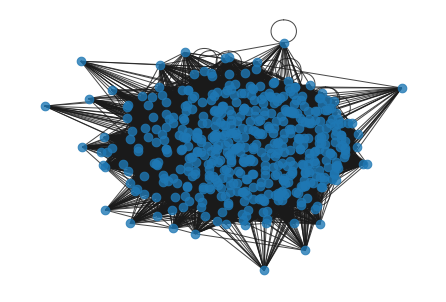

In [55]:
# import random
# import networkx as nx
# import numpy as np
# from community import community_louvain
# import matplotlib.pyplot as plt


# def generate_network(n):
#     '''
#     This function will generate a random weighted network associated to the user specifed
#     number of nodes. 
    
#     params:
#         n (Integer) : The number of nodes you want in your network
    
#     returns:
#         A networkX multi-graph
        
#     example:
#         G = generate_network(n)
#     '''
#     # initialize dictionary with nodes
#     graph_dct = {node:[] for node in range(n)}
#     nodes = list(range(n))
    
#     # generate edges
#     for n,edge_list in graph_dct.items():
#         edge_c = random.randint(min(nodes), int(max(nodes) / 2))
#         el = random.sample(nodes, edge_c)
#         graph_dct[n] = el
    
#     # create networkx multi-edge graph
#     G = nx.MultiGraph(graph_dct)
#     return G

# n = 500
# G = generate_network(n)
# print(nx.info(G))

# # visualize graph
# pos = nx.spring_layout(G)
# nx.draw(G, pos, node_size = 75, alpha = 0.8)
# plt.show()

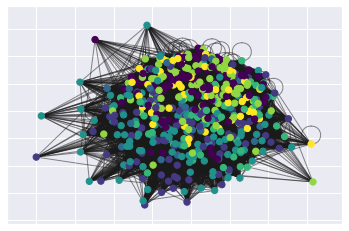

In [56]:
# import matplotlib.cm as cm

# # compute the best partition
# partition = community_louvain.best_partition(G)

# # draw the graph
# pos = nx.spring_layout(G)
# # color the nodes according to their partition
# cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
# nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
#                        cmap=cmap, node_color=list(partition.values()))
# nx.draw_networkx_edges(G, pos, alpha=0.5)
# plt.show()

In [57]:
!pip install -q torch_geometric
!pip install -q torch_sparse
!pip install -q torch_scatter

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx

     |████████████████████████████████| 564 kB 12.8 MB/s 
     |████████████████████████████████| 280 kB 35.5 MB/s 
     |████████████████████████████████| 2.1 MB 16.0 MB/s 
     |████████████████████████████████| 106 kB 17.2 MB/s 


In [123]:
from community import community_louvain

In [124]:
graph_node_ids = torch.arange(0,len(keys))
graph_node_ids = torch.reshape(graph_node_ids, (len(keys),1))


In [125]:
threshold = 0.1
graph_edges = [[],[]]
edge_weight = []
i, j = 0, 0
for i in range(similarity_array.shape[0]):
  for j in range(similarity_array.shape[1]):
    if similarity_array[i,j] >= threshold and i != j:
      if not ((i in graph_edges[0] and j in graph_edges[1]) or (j in graph_edges[0] and i in graph_edges[1])):
        graph_edges[0].append(i)
        graph_edges[1].append(j)
        edge_weight.append(similarity_array[i,j])
      # graph_edges[0].append(j)
      # graph_edges[1].append(i)
      # edge_weight.append(similarity_array[i,j])

edge_index = torch.tensor(graph_edges, dtype=torch.long)
edge_weight = torch.tensor(edge_weight, dtype=torch.float)
data = Data(x=graph_node_ids, edge_index=edge_index, edge_weight=edge_weight)
data

Data(x=[2297, 1], edge_index=[2, 12], edge_weight=[12])

In [126]:
edge_index

tensor([[ 0,  0,  1,  6, 15, 19, 25, 25, 28, 28, 30, 37],
        [25, 28, 23,  7, 17, 22, 28, 30, 42, 45, 32, 40]])

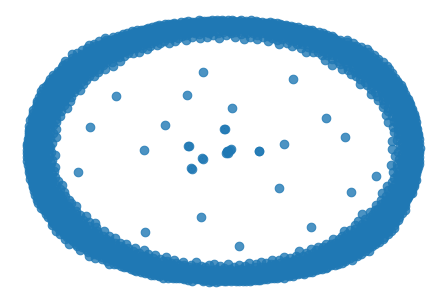

In [127]:

g = to_networkx(data, to_undirected=True)
pos = networkx.spring_layout(g)
networkx.draw(g, pos, node_size = 75, alpha = 0.8)

In [128]:
print(networkx.info(g))

Graph with 2297 nodes and 12 edges


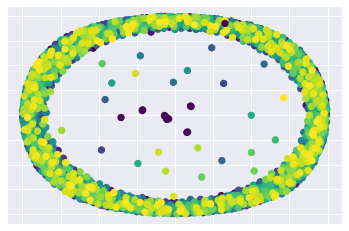

In [130]:
import matplotlib.cm as cm

# compute the best partition
partition = community_louvain.best_partition(g)

# draw the graph
pos = nx.spring_layout(g)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(g, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(g, pos, alpha=0.5)
plt.show()

In [ ]:
pd.DataFrame(similarity, 
             index=keys,
             columns=keys)

,لندن,افغانستان,رادیو,اردن,ایران,جورج,تیم,ارتش,نژاد,هنرمندان,...,پرسپولیس,تهران,پیکان,استرالیا,کارلوس,وزارت,خانه,اسپهبد,روسیه,عل
لندن,1.000000,0.037109,0.000000,0.0,0.036621,0.000000,0.000000,0.000000,0.036224,0.000000,...,0.000000,0.003145,0.000000,0.000000,0.000000,0.020386,0.000000,0.000000,0.036713,0.000000
افغانستان,0.037109,1.000000,0.027313,0.0,0.046082,0.000000,0.026901,0.007591,0.000000,0.048676,...,0.000000,0.003555,0.000000,0.000000,0.000000,0.063354,0.000000,0.000000,0.013832,0.000000
رادیو,0.000000,0.027313,1.000000,0.0,0.035797,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010414,0.000000,0.000000,0.000000,0.059052,0.000000,0.000000,0.000000,0.000000
اردن,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ایران,0.036621,0.046082,0.035797,0.0,1.000000,0.000000,0.003616,0.075562,0.033020,0.109192,...,0.030411,0.055908,0.000000,0.000000,0.000000,0.120850,0.112366,0.000000,0.036255,0.000000
جورج,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
تیم,0.000000,0.026901,0.000000,0.0,0.003616,0.000000,1.000000,0.000000,0.000000,0.011696,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.011078,0.000000,0.000000,0.000000,0.000000
ارتش,0.000000,0.007591,0.000000,0.0,0.075562,0.000000,0.000000,1.000000,0.000000,0.006603,...,0.000000,0.050171,0.000000,0.000000,0.000000,0.009377,0.000000,0.000000,0.000000,0.000000
نژاد,0.036224,0.000000,0.000000,0.0,0.033020,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
هنرمندان,0.000000,0.048676,0.000000,0.0,0.109192,0.000000,0.011696,0.006603,0.000000,1.000000,...,0.000000,0.009277,0.000000,0.000000,0.000000,0.003757,0.000000,0.000000,0.009026,0.000000


In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
x = enc.fit_transform(final_dataset[['username']]).toarray()

In [ ]:
! pip install spacy
! pip install nltk
! python -m spacy download en_core_web_sm

In [ ]:
# command to run before code


# imports and load spacy english language package
import spacy
from spacy import displacy
from spacy import tokenizer
nlp = spacy.load('en_core_web_sm')

#Load the text and process it
# I copied the text from python wiki
text ='Python is an interpreted, high-level and general-purpose programming language Pythons design philosophy emphasizes code readability withits notable use of significant indentation. Its language constructs and object-oriented approach aim to help programmers write clear and logical code for small and large-scale projects'
# text2 = # copy the paragraphs from https://www.python.org/doc/essays/
doc = nlp(text)
#doc2 = nlp(text2)
sentences = list(doc.sents)
print(sentences)
# tokenization
# for token in doc:
# 	print(token.text)
# print entities
ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
print(ents)
# # now we use displaycy function on doc2
# displacy.render(doc, style='ent', jupyter=True)


[Python is an interpreted, high-level and general-purpose programming language Pythons design philosophy emphasizes code readability withits notable use of significant indentation., Its language constructs and object-oriented approach aim to help programmers write clear and logical code for small and large-scale projects]
[]


In [ ]:
import nltk
nltk.download('words')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger')
nltk.download('state_union')
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
 
# process the text and print Named entities
# tokenization
train_text = state_union.raw()
 
sample_text = state_union.raw("2006-GWBush.txt")
custom_sent_tokenizer = PunktSentenceTokenizer(train_text)
tokenized = custom_sent_tokenizer.tokenize(sample_text)
# function
def get_named_entity():
    try:
        for i in tokenized:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            namedEnt = nltk.ne_chunk(tagged, binary=False)
            namedEnt.draw()
    except:
        pass
get_named_entity()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Unzipping corpora/state_union.zip.


In [ ]:
%%time
data_processor = DataProcessor(final_dataset,Pars_Bert_Model)

print('1) split_data() Called...')
X_train, X_test, X_validation, y_train, y_test, y_validation = data_processor.split_data(validation_spilt=0.15)
print('2) segment_df2index() Called...')
topic_indices_test = segment_df2index(X_test, segment_col='Topic')
print('3) column_selector() Called...')
X_train, X_test, X_validation = data_processor.column_selector(X_train, X_test, X_validation)
print('4) sampeler() Called...')
X_train_resampled, y_train_resampled = data_processor.sampeler(X_train, y_train, strategy='Under')
print('5) feature_extractor() Called...')
X_train_sequence, X_train_embedding, X_test_sequence, X_validation_sequence = data_processor.feature_extractor(X_train_resampled, X_test, X_validation)

1) split_data() Called...
2) segment_df2index() Called...
3) column_selector() Called...
4) sampeler() Called...
5) feature_extractor() Called...
1. Remove StopWords from Train...
2. Remove StopWords from Test...
3. Remove StopWords from Validation...
text2sequence() Called...
1. Fit Tokenizer on Train...
2. Convert Train Text to Sequence...
3. Convert Test Text to Sequence...
4. Convert Validation Text to Sequence...
Bert_Embedding() Called...
1. Extract Tarin Embedding...
CPU times: user 10min 58s, sys: 5.79 s, total: 11min 3s
Wall time: 10min 52s


In [ ]:
%%time
model = Model(
    X_train = X_train_sequence,
    y_train = y_train_resampled,
    train_embedding = X_train_embedding,
    X_validation = X_validation_sequence,
    y_validation = y_validation
               )

print('1. Define The Model...')
model.define_cnn_model()
print('2. Train The Model...')
cnn_history = model.train_cnn(epochs=50)
print('3. Plot Learning Process...')
model.plot_cnn_training_history(cnn_history)
print('4. Evaluate (all topics) The Model...')
model.Evaluate_cnn(X_test_sequence, y_test, title='Evaluation')
print('5. Topic based Evaluation...')
model.topic_based_evaluation(X_test_sequence, y_test, topic_indices_test)

1. Define The Model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 768)         236599296 
                                                                 
 dropout_2 (Dropout)         (None, None, 768)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, None, 250)         576250    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 250)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 250)         187750    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 250)        0         
 1D)                           

# Save & Load models

In [ ]:
import pickle
pickle.dump(economy_event_detection.svm_model, open('Economy_svm_model', 'wb'))
# pickle.dump(Art_event_detection.svm_model, open('Art_svm_model', 'wb'))

# model_json = economy_event_detection.cnn_model.to_json()
# with open("Economy_cnn_model.json", "w") as json_file:
#     json_file.write(model_json)
# economy_event_detection.cnn_model.save_weights("Economy_cnn_model.h5")

model_json = Art_event_detection.cnn_model.to_json()
with open("Art_cnn_model.json", "w") as json_file:
    json_file.write(model_json)
Art_event_detection.cnn_model.save_weights("Art_cnn_model.h5")



import shutil
shutil.move("/content/Economy_svm_model", "/content/gdrive/MyDrive/Event_Detection_Models")
shutil.move("/content/Art_svm_model", "/content/gdrive/MyDrive/Event_Detection_Models")
shutil.move("/content/Economy_cnn_model.json", "/content/gdrive/MyDrive/Event_Detection_Models")
shutil.move("/content/Economy_cnn_model.h5", "/content/gdrive/MyDrive/Event_Detection_Models")
shutil.move("/content/Art_cnn_model.json", "/content/gdrive/MyDrive/Event_Detection_Models")
shutil.move("/content/Art_cnn_model.h5", "/content/gdrive/MyDrive/Event_Detection_Models")

NameError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import model_from_json

json_file = open('/content/gdrive/MyDrive/Event_Detection_Models/Economy_cnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/MyDrive/Event_Detection_Models/Economy_cnn_model.h5")
print("Loaded model from disk")

## Real-Time Simulation

In [ ]:
Real_time_Prediction = Predict(tech_event_detection.svm_model,
                           tech_event_detection.cnn_model,
                           tech_processed.train_text,
                           sport_event_detection.svm_model,
                           sport_event_detection.cnn_model,
                           sport_processed.train_text)

In [ ]:
Real_time_Prediction.Main()

In [ ]:
def generate_class_weight(y_train):
    class_weights = {}
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight = "balanced", classes= classes, y= y_train)
    for i in range(len(classes)):
        class_weights[classes[i]] = weights[i]
    return class_weights